# Autoencoders

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b): 
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
bs = 256
tds = dsd.with_transform(transformi)

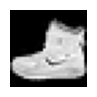

In [ ]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [ ]:
# From dataset notebook. To handle dict as hf

cf = collate_dict(ds)

In [ ]:
def collate_(b): 
    return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): 
    return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [ ]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [ ]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

In [ ]:
labels = ds.features[y].names

In [ ]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

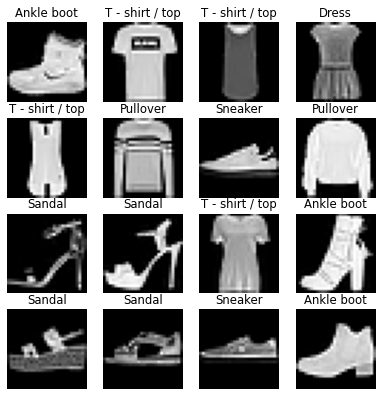

In [ ]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [ ]:
from torch import optim

bs = 256
lr = 0.4

In [ ]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [ ]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.81881753282547 0.6989
1 0.6657791373729706 0.7625
2 0.5219696167469025 0.8153
3 0.5098552591323853 0.8173
4 0.4359612995624542 0.8467


In [ ]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

Two problems: 
- It is training slowly !
- 85% is not good at all !

**Speed:**

Let's check the data that come from HF

In [ ]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

Unlike our MNIST dataset before, where the entire dataset was a large tensor, each data sample is a specific png imagefile and the code spends most of its time decoding the png files at each step. And this is using the CPU only !!!

Can use this command to observe the utilization of the GPU: `nvidia-smi dmon`

To monitor the CPU: `htop` or `top`

First it is possible to use more CPU cores than one, by adding `num_workers` un data_loaders

In [ ]:
def collate_(b): 
    return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): 
    return {k:DataLoader(v, bs, num_workers=8, **kwargs) for k,v in dsd.items()}

In [ ]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [ ]:
dt = dls['train']
dv = dls['test']

try:
    xb,yb = next(iter(dt))
except Exception as err:
    print(err)

Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/vtec/miniconda3/envs/course22p2/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/vtec/miniconda3/envs/course22p2/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/tmp/ipykernel_144/2766026907.py", line 2, in collate_
    return to_device(cf(b))
  File "/home/vtec/projects/fastai/course22p2/miniai/conv.py", line 32, in to_device
    return type(x)(o.to(device) for o in x)
  File "/home/vtec/projects/fastai/course22p2/miniai/conv.py", line 32, in <genexpr>
    return type(x)(o.to(device) for o in x)
  File "/home/vtec/miniconda3/envs/course22p2/lib/python3.10/site-packages/torch/cuda/__init__.py", line 207, in _lazy_init
    raise RuntimeError(
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA wit

Problem is that we want to use multiple workers AND our collate function puts the data on the GPU.

This is not compatible !

This means we would have to rewrite our `fit` function, which we do not want to have to do

In [ ]:
def collate_(b): 
    return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): 
    return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [ ]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [ ]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

## Autoencoder

We upsize the incoming feature map to increase the size, then apply a stride 1 convolution to it

Explanation in lecture video [here](https://youtu.be/CQvMI7lxKU8?t=5143)

In [ ]:
def deconv(ni, nf, ks=3, act=True):
    """Applies Upsampling and then a stride 1 convolution"""
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [ ]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

B/c images are small, we first increase the size to 32 x 32 by padding

In [ ]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [ ]:
eval(ae, F.mse_loss, dv)

0 0.178


In [ ]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.017
1 0.015
2 0.014
3 0.014
4 0.014


In [ ]:
opt = optim.AdamW(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.013
1 0.013
2 0.013
3 0.013
4 0.014


In [ ]:
opt = optim.AdamW(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.013
1 0.013
2 0.013
3 0.012
4 0.013


In [ ]:
# opt = optim.AdamW(ae.parameters(), lr=0.01)
# fit(5, ae, F.l1_loss, opt, dt, dv)

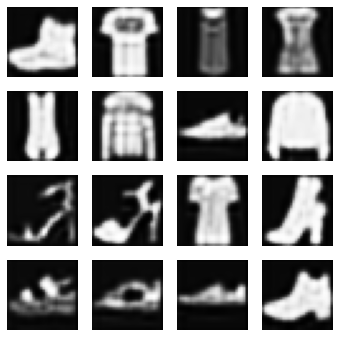

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

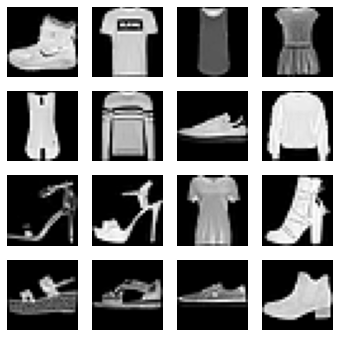

In [ ]:
show_images(xb[:16].data.cpu(), imsize=1.5)

We could try lots of things, but at the moment we would need to recode every single line of code for each option, and this will dry us crazy and be error prone [in video](https://youtu.be/CQvMI7lxKU8?t=5691).

We need a framework